In [1]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
# import scanpy as sc
# import scvelo as scv

# data = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC_level1_rep_cells.h5ad')
# data.shape

In [3]:
# label = data.obs['celltype.l1'].tolist()
# types = np.unique(label).tolist()
types = ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

## Read result_dict from json

In [4]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level_1_alpha0.01/Level1_result


In [5]:
import json

loss_dict = {}
opt_lambda_dict = {}
prevalence_dict = {}
for celltype in types:
    print('Processing: ', celltype)
    # /Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/PBMC_AD2_result/ASDC
    with open(f'./{celltype}/{celltype}_tuning.json') as f:
        result_dict = json.load(f)
    result_dict = {key: np.array(value) for key, value in result_dict.items()}

    # opt_lmbd, fig = ad.lambda_decision(result_dict, k=2)
    # opt_lambda_dict[celltype] = opt_lmbd
    # print('Optimal lambda: {}'.format(opt_lmbd))

    # Read optimal lambda
    with open(f'./{celltype}/{celltype}_opt_lambda.txt', 'r') as f:
        opt_lmbd = float(f.read())
    opt_lambda_dict[celltype] = opt_lmbd

    loss_dict[celltype] = result_dict['loss_history']
    prevalence_dict[celltype] = result_dict['Prevalence']

Processing:  B
Processing:  CD4 T
Processing:  CD8 T
Processing:  DC
Processing:  Mono
Processing:  NK
Processing:  other
Processing:  other T


In [6]:
opt_lambda_dict

{'B': 0.0014677992676220707,
 'CD4 T': 0.014677992676220709,
 'CD8 T': 0.0021544346900318864,
 'DC': 0.06812920690579614,
 'Mono': 0.004641588833612781,
 'NK': 0.0021544346900318864,
 'other': 0.046415888336127815,
 'other T': 0.046415888336127815}

In [7]:
# with open('./Pancreas_ADlasso/Pancreas_result/opt_lambda.json', 'w') as f:
#     json.dump(opt_lambda_dict, f)

## Plot summary loss vs. prevalance

In [8]:
log_lmbd_range = np.linspace(np.log(1e-4), np.log(1), 25)
lmbd_range = np.exp(log_lmbd_range)
print(lmbd_range)

[1.00000000e-04 1.46779927e-04 2.15443469e-04 3.16227766e-04
 4.64158883e-04 6.81292069e-04 1.00000000e-03 1.46779927e-03
 2.15443469e-03 3.16227766e-03 4.64158883e-03 6.81292069e-03
 1.00000000e-02 1.46779927e-02 2.15443469e-02 3.16227766e-02
 4.64158883e-02 6.81292069e-02 1.00000000e-01 1.46779927e-01
 2.15443469e-01 3.16227766e-01 4.64158883e-01 6.81292069e-01
 1.00000000e+00]


In [9]:
# create color palette for 8 cell types
import seaborn as sns

keys = list(loss_dict.keys())
palette = sns.color_palette('tab20', n_colors=len(keys))
color_dict = dict(zip(keys, palette))

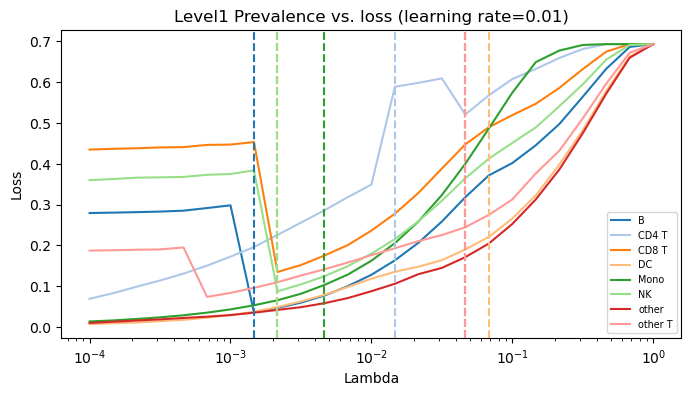

In [10]:
# Plot the loss history against lambda
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in loss_dict:
    ax.plot(lmbd_range, loss_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Loss')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Level1 Prevalence vs. loss (learning rate=0.01)')

# show the plot
plt.show()

## Count feature number

In [8]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level_1_alpha0.01/Level1_result


In [10]:
feature_count = {}

for celltype in types:
    try:
        feature_df = pd.read_csv(f'./{celltype}/{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
    except:
        print('skipping:', celltype)
        continue
    
    feature_no = feature_df.shape[0]
    positive_feature_no = feature_df[feature_df['Tendency'] == 1].shape[0]
    feature_count[celltype] = [feature_no, positive_feature_no]
    print(celltype, 'Feature count:', feature_no)
    print(celltype, 'Positive feature count:', positive_feature_no)
    print('------------------')

B Feature count: 17
B Positive feature count: 9
------------------
CD4 T Feature count: 1786
CD4 T Positive feature count: 36
------------------
CD8 T Feature count: 26
CD8 T Positive feature count: 9
------------------
DC Feature count: 1
DC Positive feature count: 0
------------------
Mono Feature count: 22
Mono Positive feature count: 14
------------------
NK Feature count: 27
NK Positive feature count: 15
------------------
other Feature count: 1
other Positive feature count: 0
------------------
other T Feature count: 2
other T Positive feature count: 0
------------------


In [11]:
feature_count

{'B': [17, 9],
 'CD4 T': [1786, 36],
 'CD8 T': [26, 9],
 'DC': [1, 0],
 'Mono': [22, 14],
 'NK': [27, 15],
 'other': [1, 0],
 'other T': [2, 0]}

In [13]:
feature_count_df = pd.DataFrame.from_dict(feature_count, orient='index', columns=['Total', 'Positive'])
feature_count_df

,Total,Positive
B,17,9
CD4 T,1786,36
CD8 T,26,9
DC,1,0
Mono,22,14
NK,27,15
other,1,0
other T,2,0


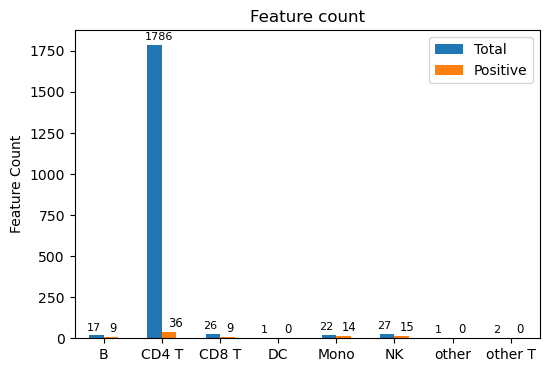

In [47]:
# Plot total feature count and positive feature count
ax = feature_count_df.plot.bar(rot=0, figsize=(6, 4))
ax.set_ylabel('Feature Count')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_title('Feature count')

# Add the y-values to the bars
for i, v in enumerate(feature_count_df['Total']):
    ax.text(i-0.3, v+30, str(v), size=8)
for i, v in enumerate(feature_count_df['Positive']):
    ax.text(i+0.1, v+30, str(v), size='small')

In [20]:
# Gapped y-axis example

import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots

# data
df = pd.DataFrame({'years': [1995, 1996, 1997, 1998, 1999, 2000,
                             2001, 2002, 2003, 2004, 2005, 2006,
                             2007, 2008, 2009, 2010, 2011, 2012],
                  'China': [219, 146, 112, 127, 124, 180, 236,
                            207, 236, 263,350, 430, 474, 1526,
                            488, 537, 500, 439],
                  'Rest of world': [16, 13, 10, 11, 28, 37,
                                        43, 55, 56, 88, 105, 156, 270,
                                        299, 340, 403, 549, 1499]})
df.set_index('years', inplace = True)

# colors and cut-offs
colors = px.colors.qualitative.Plotly
cut_interval = [600, 1400]

# subplot setup
fig = make_subplots(rows=2, cols=1, vertical_spacing = 0.04)
fig.update_layout(title = "USA plastic scrap exports (...with some made-up values)")

# Traces for [2, 1]
# marker_color=colors[i] ensures that categories follow the same color cycle
for i, col in enumerate(df.columns):
    fig.add_trace(go.Bar(x=df.index,
                    y=df[col],
                    name=col,
                    marker_color=colors[i],
                    legendgroup = col,
                    ), row=2, col=1)

# Traces for [1, 1]
# Notice that showlegend = False.
# Since legendgroup = col the interactivity is
# taken care of in the previous for-loop.
for i, col in enumerate(df.columns):
    fig.add_trace(go.Bar(x=df.index,
                    y=df[col],
                    name=col,
                    marker_color=colors[i],
                    legendgroup = col,
                    showlegend = False,
                    ), row=1, col=1)

# Some aesthetical adjustments to layout
fig.update_yaxes(range=[cut_interval[1], max(df.max()*1.1)], row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_yaxes(range=[0, cut_interval[0]], row=2, col=1)

fig.show()